In [35]:
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from math import pi, cos, sin, gcd
from fractions import Fraction
import math as m

In [8]:
psi1 = Statevector([m.cos(m.pi / 8), m.sin(m.pi / 8)])
psi2 = Statevector([m.cos(5 * m.pi / 8), m.sin(5 * m.pi / 8)])

In [9]:
H = Operator(psi1) - Operator(psi2)
array_to_latex(H)

<IPython.core.display.Latex object>

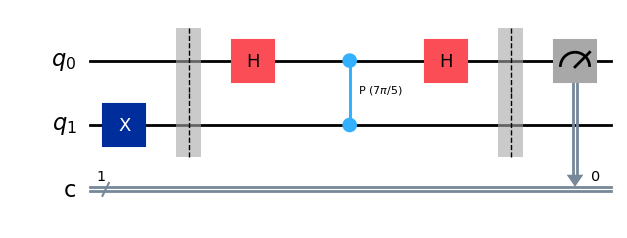

In [11]:
theta = 0.7
qc = QuantumCircuit(2, 1)

qc.x(1)
qc.barrier()

# Implementing the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

qc.measure(0, 0)

qc.draw("mpl")

In [13]:
Sampler().run(qc).result().quasi_dists[0]

{0: 0.345491502812526, 1: 0.654508497187474}

In [14]:
display({
    0: cos(pi * theta) ** 2,
    1: sin(pi * theta) ** 2
})

{0: 0.34549150281252616, 1: 0.6545084971874737}

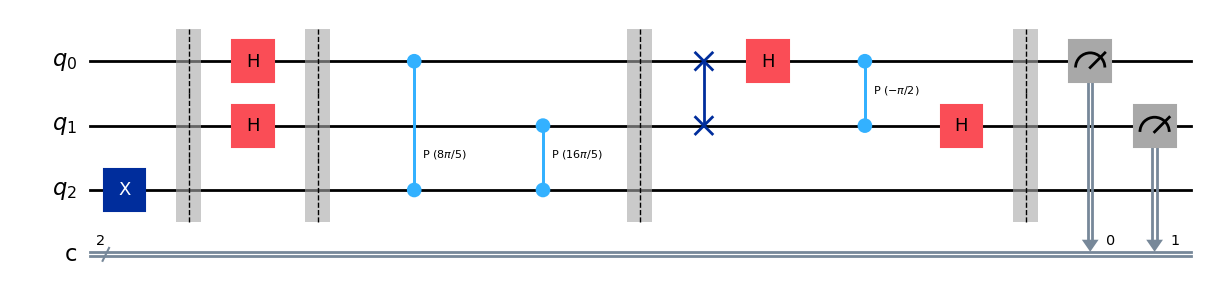

In [16]:
theta = 0.8
qc = QuantumCircuit(3, 2)

# Preparing the eigenvector
qc.x(2)
qc.barrier()

# Initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2*theta), 1, 2)
qc.barrier()

# Implementing the inverse of the two-q.bit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

qc.measure([0, 1], [0, 1])
qc.draw("mpl")

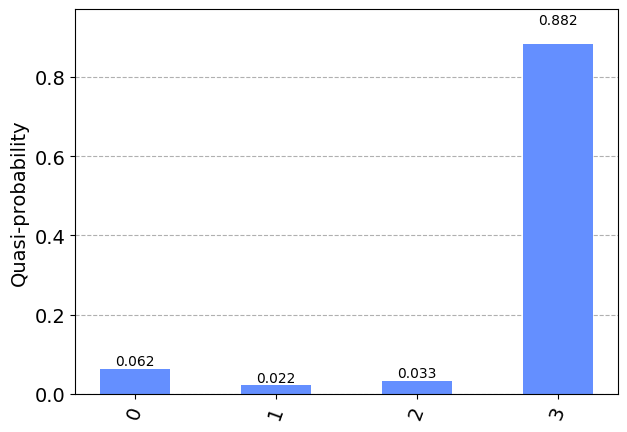

In [18]:
result = Sampler().run(qc).result()
plot_histogram(result.quasi_dists)

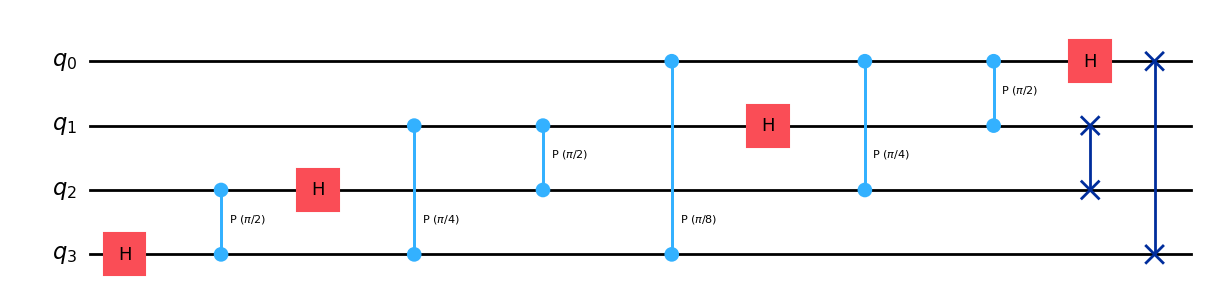

In [20]:
QFT(4).decompose().draw("mpl")

In [22]:
theta = 0.7
m = 3 # number of control q.bits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

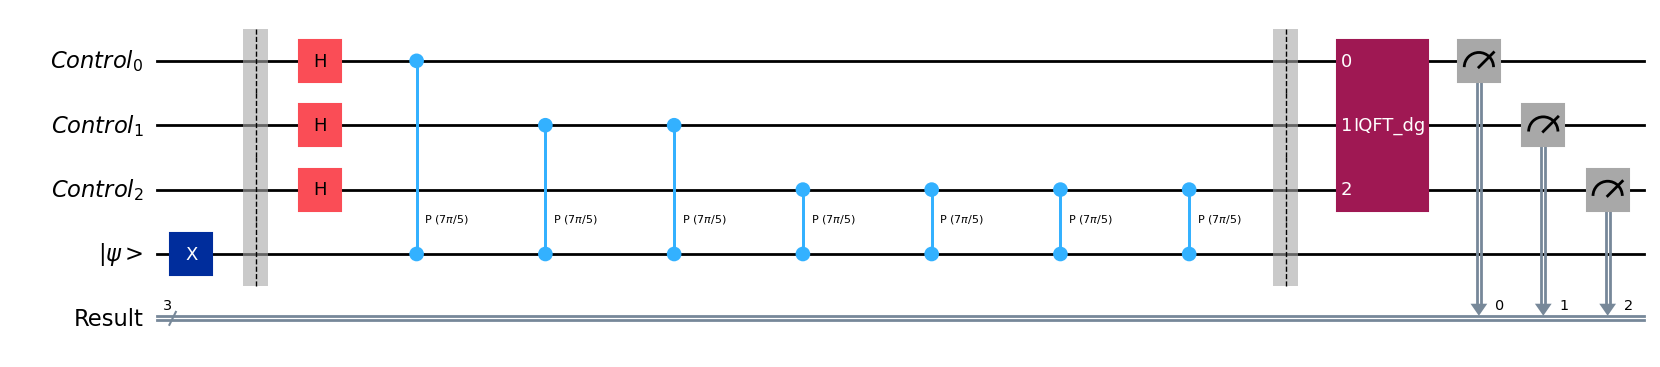

In [23]:
# Prepare the eigenvecter |ψ>
qc.x(target_register)
qc.barrier()

# Perform the phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target_register)
qc.barrier()

# Do the inverse Fourier transformation
qc.compose(
    QFT(m, inverse=True),
    inplace=True
)

qc.measure(range(m), range(m))
qc.draw("mpl")

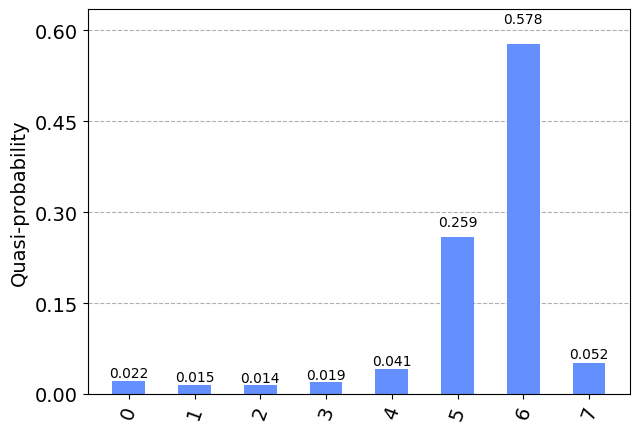

In [25]:
result = Sampler().run(qc).result()
plot_histogram(result.quasi_dists)

In [27]:
most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75


In [29]:
N = 21
a = 17
max_power = 12

print("k \t a^k \n")
for k in range(1, max_power + 1):
    print(
        "%2d \t %2d" % (k, a**k % N)
    ) # The % operation computes the remainder modulo N

k 	 a^k 

 1 	 17
 2 	 16
 3 	 20
 4 	  4
 5 	  5
 6 	  1
 7 	 17
 8 	 16
 9 	 20
10 	  4
11 	  5
12 	  1


In [30]:
N = 21
a = 18
max_power = 12

print("k \t a^k \n")
for k in range(1, max_power+1):
    print("%2d \t %2d" % (k, a**k % N))

k 	 a^k 

 1 	 18
 2 	  9
 3 	 15
 4 	 18
 5 	  9
 6 	 15
 7 	 18
 8 	  9
 9 	 15
10 	 18
11 	  9
12 	 15


In [31]:
def c_amod15(a):
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")

    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

In [32]:
def phase_estimation(
    controlled_operation: QuantumCircuit,
    psi_prep: QuantumCircuit,
    precision: int
):
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)

    # prepare state
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)

    # Do Phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True
            )

    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )

    qc.measure(control_register, output_register)

    measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return measurement / 2**precision

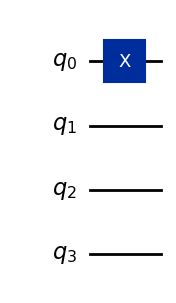

In [33]:
psi_prep = QuantumCircuit(4)
psi_prep.x(0)
psi_prep.draw("mpl")

In [42]:
a = 8
N = 15

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amod15(a),
        psi_prep,
        precision=8
    )
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1, 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True


Attempt 1

Attempt 2
Non-trivial factor found: 3
